In [3]:
# %% Import libraries
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import seaborn as sns
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, \
                                    cross_val_score, \
                                    cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, \
                                    accuracy_score, \
                                    precision_score, \
                                    recall_score, \
                                    classification_report
from tpot import TPOTClassifier

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
# function definitions

def pca(df):
    
    # standardize the features matrix
    features = StandardScaler().fit_transform(df)
    
    # Create a PCA that retains 99% of the variance
    pca = PCA(n_components = 0.95)
    features_pca = pca.fit_transform(features)
    
    return features, features_pca


def plot_cm(cm):
    # plot confusion matrix
    fig, ax = plt.subplots(figsize = (10,8))
    
    sns.heatmap(conf_matrix_rf/np.sum(conf_matrix_rf), annot=True, 
                fmt='.2%', cmap='Blues', annot_kws={'size':15})
    
    ax.set_title('Random Forest Confusion Matrix', fontsize = 18, loc='left')
    
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12)
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 12)
    
    plt.show()

In [6]:
# %% read df_final
# Read the Kepler Objects of Interest (KOI) df_final and look at one observation
df_koi = pd.read_csv('../data/cumulative_2021.03.16_17.10.21.csv')
print(df_koi.shape)
print(df_koi[1:2].T)

(9564, 141)
                                                                    1
rowid                                                               2
kepid                                                        10797460
kepoi_name                                                  K00752.02
kepler_name                                              Kepler-227 c
koi_disposition                                             CONFIRMED
koi_vet_stat                                                     Done
koi_vet_date                                                8/16/2018
koi_pdisposition                                            CANDIDATE
koi_score                                                       0.969
koi_fpflag_nt                                                       0
koi_fpflag_ss                                                       0
koi_fpflag_co                                                       0
koi_fpflag_ec                                                       0
koi_disp

#### clean data  

In [7]:
# Remove variables with no data
df_koi_cleaned = df_koi.dropna(axis=1, how='all')
# Remove variables with no data
df_koi_cleaned = df_koi_cleaned.loc[:, (df_koi_cleaned != 0).any(axis=0)]
# Remove the err columns
df_koi_cleaned = df_koi_cleaned[df_koi_cleaned.columns.drop(
    list(df_koi_cleaned.filter(regex='_err')))]
# Still some variables that are all 0.0; will just drop them manually...
cols = ['koi_eccen','koi_ldm_coeff4','koi_ldm_coeff3']
df_koi_cleaned = df_koi_cleaned.drop(cols,axis=1)

In [8]:
df_koi_cleaned.shape
# %% describe
df_describe = pd.DataFrame(df_koi_cleaned.describe())
print(df_describe)

             rowid         kepid    koi_score  koi_fpflag_nt  koi_fpflag_ss  \
count  9564.000000  9.564000e+03  8054.000000    9564.000000    9564.000000   
mean   4782.500000  7.690628e+06     0.480829       0.208595       0.232748   
std    2761.033321  2.653459e+06     0.476928       4.767290       0.422605   
min       1.000000  7.574500e+05     0.000000       0.000000       0.000000   
25%    2391.750000  5.556034e+06     0.000000       0.000000       0.000000   
50%    4782.500000  7.906892e+06     0.334000       0.000000       0.000000   
75%    7173.250000  9.873066e+06     0.998000       0.000000       0.000000   
max    9564.000000  1.293514e+07     1.000000     465.000000       1.000000   

       koi_fpflag_co  koi_fpflag_ec     koi_period  koi_time0bk     koi_time0  \
count    9564.000000    9564.000000    9564.000000  9564.000000  9.564000e+03   
mean        0.197512       0.120033      75.671358   166.183251  2.454999e+06   
std         0.398142       0.325018    1334.7

#### prepare data

In [9]:
"""
Remove all descriptive variables to further simplify the df_final
In the interest of time, remove all categorical variables
"""
remove_cols = ['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_vet_stat',
               'koi_vet_date', 'koi_pdisposition', 'koi_fpflag_nt',
               'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_disp_prov',
               'koi_comment', 'koi_limbdark_mod', 'koi_parm_prov', 'koi_tce_delivname',
               'koi_trans_mod', 'koi_trans_mod', 'koi_datalink_dvr', 'koi_datalink_dvs',
               'koi_sparprov', 'koi_fittype']
df_final = df_koi_cleaned.drop(remove_cols, axis=1)

In [10]:
# Separate labels from features
labels = df_final['koi_disposition']
df_features = df_final.drop(['koi_disposition'], axis=1)

# Separate labels from features
imputer = SimpleImputer(strategy="median")
imputer.fit(df_features)
X = imputer.transform(df_features)
df_final = pd.DataFrame(X, columns=df_features.columns, index=df_features.index)

#### Dimensionality Reduction

In [11]:
features, features_pca = pca(df_final)
print('Original number of features: {}'.format(features.shape[1]))
print('Reduced number of features: {}'.format(features_pca.shape[1]))
df_final = pd.DataFrame(df_final, columns=df_final.columns, index=df_final.index)

Original number of features: 53
Reduced number of features: 29


In [12]:
# %% train and test sets
# labels = np.array(labels)
train_features, test_features, train_labels, test_labels = train_test_split(
    df_final, labels, test_size = 0.25, random_state = 42)

In [13]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
print('Training distribution: ',train_labels.value_counts(normalize=True))
print('Test distribution: ',test_labels.value_counts(normalize=True))

Training Features Shape: (7173, 53)
Training Labels Shape: (7173,)
Testing Features Shape: (2391, 53)
Testing Labels Shape: (2391,)
Training distribution:  FALSE POSITIVE    0.508853
CANDIDATE         0.246062
CONFIRMED         0.245086
Name: koi_disposition, dtype: float64
Test distribution:  FALSE POSITIVE    0.497700
CANDIDATE         0.251359
CONFIRMED         0.250941
Name: koi_disposition, dtype: float64


#### train baseline model

In [14]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(train_features, train_labels)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [13]:
predictions = rf.predict(test_features)
print("Accuracy score: ", accuracy_score(test_labels, predictions))
print("Recall score: ", recall_score(test_labels, predictions, average=None))
cv_score = cross_val_score(rf, train_features, train_labels, cv=3, scoring='accuracy')
print("Cross validation score: ", cv_score)
print(classification_report(test_labels,predictions))

Accuracy score:  0.8649100794646591
Recall score:  [0.66222962 0.87166667 0.96386555]
Cross validation score:  [0.85027185 0.85570891 0.8460895 ]
                precision    recall  f1-score   support

     CANDIDATE       0.79      0.66      0.72       601
     CONFIRMED       0.86      0.87      0.87       600
FALSE POSITIVE       0.90      0.96      0.93      1190

      accuracy                           0.86      2391
     macro avg       0.85      0.83      0.84      2391
  weighted avg       0.86      0.86      0.86      2391



#### confusion matrix

[[1110  285  370]
 [ 199 1517   42]
 [ 167    8 3475]]


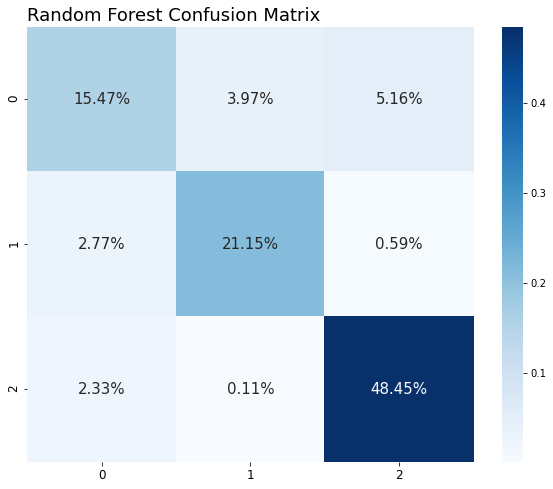

In [15]:
train_pred = cross_val_predict(rf, train_features,train_labels, cv=3)
conf_matrix_rf = confusion_matrix(train_labels, train_pred)
print(conf_matrix_rf)
plot_cm(conf_matrix_rf)

#### randomized search

In [16]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_2 = RandomForestClassifier(random_state = 42)

Random search of parameters, using 3 fold cross validation, search across 100 different combinations, and use all available cores

In [17]:
rf_random = RandomizedSearchCV(estimator = rf_2, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, verbose=2)

In [17]:
# %% best params - use these params for the next model
print(rf_random.best_params_)

{'n_estimators': 522, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}


#### Model with Random Search CV Params

In [18]:
rf_rs = RandomForestClassifier(n_estimators = 522,
                               min_samples_split = 2,
                               min_samples_leaf = 2,
                               max_features = 'sqrt',
                               max_depth = 110,
                               bootstrap = False)

In [19]:
rf_rs.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=False, max_depth=110, max_features='sqrt',
                       min_samples_leaf=2, n_estimators=522)

In [20]:
print(rf_rs.score(train_features, train_labels))
y_pred = rf_rs.predict(test_features)
print(accuracy_score(test_labels, y_pred))
print(classification_report(test_labels, y_pred))

1.0
0.862818904224174
                precision    recall  f1-score   support

     CANDIDATE       0.78      0.66      0.72       601
     CONFIRMED       0.86      0.87      0.87       600
FALSE POSITIVE       0.90      0.96      0.93      1190

      accuracy                           0.86      2391
     macro avg       0.85      0.83      0.84      2391
  weighted avg       0.86      0.86      0.86      2391



[[ 356  108  137]
 [  64  522   14]
 [  55    3 1132]]


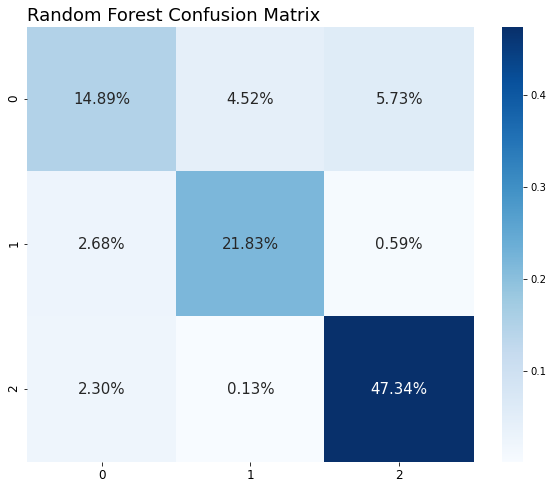

In [23]:
# confusion matrix & accuracy
rs_pred = cross_val_predict(rf_rs, test_features,test_labels, cv=3)
conf_matrix_rf = confusion_matrix(test_labels, rs_pred)
print(conf_matrix_rf)
plot_cm(conf_matrix_rf)

In [24]:
print("Accuracy score: ", accuracy_score(test_labels, rs_pred))
print("Recall score: ", recall_score(test_labels, rs_pred, average=None))
print("Precision score: ", precision_score(test_labels, rs_pred, average=None))

Accuracy score:  0.8406524466750314
Recall score:  [0.59234609 0.87       0.9512605 ]
Precision score:  [0.74947368 0.82464455 0.88230709]


In [28]:
# TPOT

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}

In [29]:
tpot_classifier = TPOTClassifier(generations= 5, 
                                 population_size= 24, 
                                 offspring_size= 12,
                                 verbosity= 2, 
                                 early_stop= 12,
                                 config_dict={'sklearn.ensemble.RandomForestClassifier': param}, 
                                 cv = 4, 
                                 scoring = 'accuracy')
tpot_classifier.fit(train_features, train_labels)
accuracy = tpot_classifier.score(test_features, test_labels)
print(accuracy)

Optimization Progress:   0%|          | 0/84 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.853478876418327

Generation 2 - Current best internal CV score: 0.853478876418327

Generation 3 - Current best internal CV score: 0.8538971697814056

Generation 4 - Current best internal CV score: 0.8538971697814056

Generation 5 - Current best internal CV score: 0.8538971697814056

Best pipeline: RandomForestClassifier(CombineDFs(input_matrix, input_matrix), criterion=entropy, max_depth=230, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600)


ValueError: could not convert string to float: 'CANDIDATE'

#### AdaBoost Classifier

In [26]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5)

ada_clf.fit(train_features, train_labels)
ada_pred = ada_clf.predict(test_features)

In [27]:
print(classification_report(test_labels, ada_pred))

                precision    recall  f1-score   support

     CANDIDATE       0.69      0.59      0.64       601
     CONFIRMED       0.82      0.87      0.84       600
FALSE POSITIVE       0.89      0.93      0.91      1190

      accuracy                           0.83      2391
     macro avg       0.80      0.80      0.80      2391
  weighted avg       0.82      0.83      0.82      2391



#### SVM

In [64]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(train_features, train_labels)
svm_preds = svm_clf.predict(test_features)

In [65]:
print(classification_report(test_labels, ada_pred))

                precision    recall  f1-score   support

     CANDIDATE       0.69      0.59      0.64       601
     CONFIRMED       0.82      0.87      0.84       600
FALSE POSITIVE       0.89      0.93      0.91      1190

      accuracy                           0.83      2391
     macro avg       0.80      0.80      0.80      2391
  weighted avg       0.82      0.83      0.82      2391



### Multi-classification using Keras

In [31]:
# Vectorize the labels
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

ValueError: invalid literal for int() with base 10: 'CANDIDATE'

In [73]:
# Build and compile a model
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(53,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [74]:
# Train the model
history = model.fit(train_features,
                    train_labels,
                    epochs=20,
                    batch_size=512,
                    validation_data=(test_features, test_labels))

Epoch 1/20


ValueError: in user code:

    /home/will/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/will/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/will/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/will/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/will/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/will/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/will/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /home/will/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/will/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /home/will/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/will/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/will/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /home/will/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/will/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/will/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 46) are incompatible


In [ ]:
results = history.evaluate(test_features, one_hot_test_labels)

In [ ]:
# Plot loss and accuracy curves
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()